# Familarizing with the dataset

We familiarize with the CALVIN dataset, which provides a debug split.

## Imports

In [1]:
import os
from IPython.display import display
from PIL import Image

import numpy as np
import yaml

In [2]:
try:
    from yaml import CLoader as Loader, CDumper as Dumper
except ImportError:
    from yaml import Loader, Dumper

In [3]:
DATA_PATH = "../data/calvin/calvin_debug_dataset/"
train_path = os.path.join(DATA_PATH, "training")
val_path = os.path.join(DATA_PATH, "validation")

## Metadata

There are some files providing metadata. Let's take a look at them:

### ep_lens and ep_start_end_ids

seems that count the total number of frames and the start and end ids

In [4]:
ep_lens = np.load(os.path.join(train_path, "ep_lens.npy"))
ep_start_end_ids = np.load(os.path.join(train_path, "ep_start_end_ids.npy"))

In [5]:
print(ep_lens)
print(ep_start_end_ids)

2771
[[358482 361252]]


In [6]:
np.subtract.reduce(ep_start_end_ids.squeeze()[::-1])

2770

If I'm understanding this correctly, they only included one episode in the debug dataset, of 2770 frames (or is it 2771?). Normally there would be multiple episodes, so that the ep_lens and ep_start_end_ids files would be more useful, containing the length and start and end ids for each episode. 

Note that the authors use the word "episode" to refer to a frame. See [this issue comment](https://github.com/mees/calvin/issues/23#issuecomment-1202270412).

Note that:

episode = trajectory of play data.

Within one trajectory of play data, there can be several task trajectories. For example, while "playing", a user may turn on a light switch and then move a block to the right. This single episode trajectory would end up displaying two tasks, namely "turning on the light" and "moving the block to the right"

We can see this in the [language annotations section](#Language-Annoations), where even though we have a single "episode" in the debug dataset, we have trajectories for multiple tasks.

### scene_info

In [7]:
# this is an object array so we need to pass allow_pickle=True
scene_info = np.load(os.path.join(train_path, "scene_info.npy"), allow_pickle=True)

In [8]:
scene_info

array({'calvin_scene_D': [358482, 361252]}, dtype=object)

See [this issue](https://github.com/mees/calvin/issues/14) for an explanation of what is here. TLDR: tells you which of the 4 possible scenes (A, B, C, or D) a given range of frames come from.

### statistics.yaml

In [9]:
with open(os.path.join(train_path, "statistics.yaml"), "r") as stream:
    try:
        statistics = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

In [10]:
statistics

{'robot_obs': [{'_target_': 'calvin_agent.utils.transforms.NormalizeVector',
   'mean': [0.039233,
    -0.118554,
    0.507826,
    1.079174,
    -0.083069,
    1.579753,
    0.054622,
    -0.736859,
    1.017769,
    1.792879,
    -2.099604,
    -0.993738,
    1.790842,
    0.586534,
    0.095367],
   'std': [0.150769,
    0.1104,
    0.06253,
    2.883517,
    0.126405,
    0.377196,
    0.030152,
    0.334392,
    0.172714,
    0.240513,
    0.3842,
    0.198596,
    0.158712,
    0.346865,
    0.995442]}],
 'scene_obs': [{'_target_': 'calvin_agent.utils.transforms.NormalizeVector',
   'mean': [0.150934,
    0.119917,
    0.000239,
    0.042049,
    0.487755,
    0.47448,
    0.057482,
    -0.088074,
    0.431237,
    0.046034,
    0.030599,
    0.027333,
    0.062103,
    -0.092833,
    0.430236,
    -0.054962,
    0.019381,
    0.096546,
    0.064944,
    -0.093058,
    0.428381,
    0.024941,
    0.002746,
    -0.031589],
   'std': [0.125757,
    0.09654,
    0.002148,
    0.0419

## Single image

In [11]:
npz_file = np.load(os.path.join(train_path, "episode_0358720.npz"))

In [12]:
[filename for filename in npz_file.files]

['actions',
 'rel_actions',
 'robot_obs',
 'scene_obs',
 'rgb_static',
 'rgb_gripper',
 'rgb_tactile',
 'depth_static',
 'depth_gripper',
 'depth_tactile']

In [13]:
with npz_file as f:
    rgb_static = f["rgb_static"]

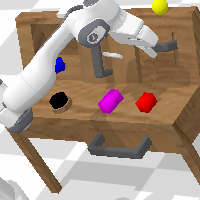

In [14]:
Image.fromarray(rgb_static)

## Language Annoations

In [15]:
# this is an object array so we need to pass allow_pickle=True

lang_annotations = np.load(
    os.path.join(train_path, "lang_annotations", "auto_lang_ann.npy"), allow_pickle=True
)

In [16]:
lang_annotations_dict = lang_annotations.item()

In [17]:
lang_annotations_dict['info']

{'episodes': [],
 'indx': [(358656, 358720),
  (359714, 359757),
  (360978, 361011),
  (358728, 358792),
  (359534, 359598),
  (360571, 360635),
  (358729, 358793),
  (359069, 359103),
  (360575, 360639)]}

In [18]:
lang_annotations_dict['language']['ann']

['move the light switch to turn on the yellow light',
 'sweep the pink block to the right',
 'place the block in the sliding cabinet',
 'pick up the red block from the table',
 'in the slider grasp the blue block',
 'slide down the switch',
 'pick up the red block on the table',
 'place in slider',
 'turn off the light bulb']

In [19]:
len(lang_annotations_dict['language']['ann'])

9

## Ordering

In [20]:
# get array images
# the images we are interested in are the ones at the end of the task trajectories
# as specified by the language annotations

image_idxs = [end for (start, end) in lang_annotations_dict["info"]["indx"]]

images = [
    Image.fromarray(
        np.load(os.path.join(train_path, f"episode_0{idx}.npz"))["rgb_static"]
    )
    for idx in image_idxs
]

In [21]:
# get language_annotations
lang_anns = lang_annotations_dict['language']['ann']

move the light switch to turn on the yellow light


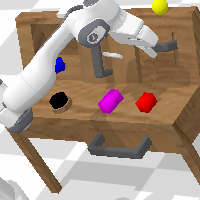



sweep the pink block to the right


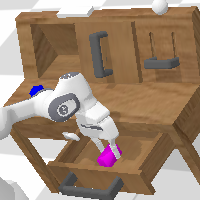



place the block in the sliding cabinet


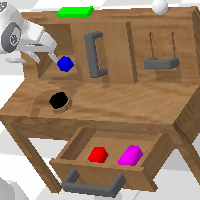



pick up the red block from the table


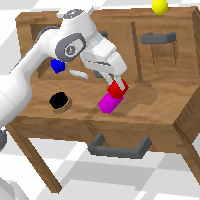



in the slider grasp the blue block


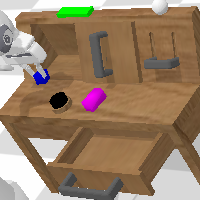



slide down the switch


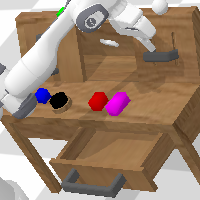



pick up the red block on the table


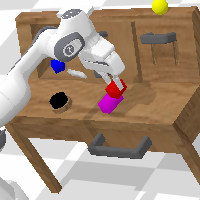



place in slider


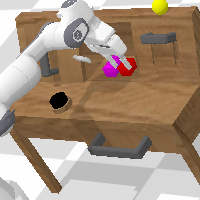



turn off the light bulb


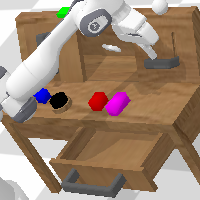

In [22]:
for lang_ann, image in zip(lang_anns, images):
    print(lang_ann)
    display(image)
    print('\n')

The images and text are already well-paired.